In [45]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [46]:
import numpy as np
import os
import copy

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import Src.YamlUtils as yu
import Src.DicData as dade
import Src.Slideshow as slide
import Src.KerasSequence as ks
import Src.ImgProcessing as img_proc
import Src.OversampleStreamData as osa
import Src.Speed as speed
import Src.Models as models
import Src.KerasCallbacks as kc

In [3]:
img_path = "Z:/ForschB/NeuroRace-Sim/forschB_data/{}/depth_camera/rgb/image_raw/compressed"
train_path = "Z:/ForschB/NeuroRace-Sim/forschB_data"

valid_img_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_counter/{}/depth_camera/rgb/image_raw/compressed"
valid_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_counter"


dirs = os.listdir(train_path)
valid_dirs = os.listdir(valid_path)


yamls = []

for d in dirs:
    yamls.append("{}/{}/{}.yaml".format(train_path, d, d))
    
    
valid_yamls = []

for d in valid_dirs:
    valid_yamls.append("{}/{}/{}.yaml".format(valid_path, d, d))

In [4]:
mean_over_img_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_mean_over/{}/imgs"
mean_over_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_mean_over"

mean_over_dirs = os.listdir(mean_over_path)

mean_over_yamls = []

for d in mean_over_dirs:
    mean_over_yamls.append("{}/{}/{}.yaml".format(mean_over_path, d, "training"))

In [5]:
dicts = []

for y in yamls:
    dicts.append(dade.convert_neuro_data_to_yaml(y))
    
valid_dicts = []

for y in valid_yamls:
    valid_dicts.append(dade.convert_neuro_data_to_yaml(y))

In [6]:
mean_over_dicts = []

for y in mean_over_yamls:
    mean_over_dicts.append(yu.read_yaml(y))

In [7]:
def do_all(dic):
    dade.remove_data_with_speed_lower_than_threshold(dic)
    max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dic)
    
    # dade.add_speed_classes_to_dic(dic, threshold=0.05)
    
    # dade.normalize_dic_steering(dic, max_abs_steer)
    dade.normalize_dic_speed(dic, 10)
    
    dade.add_speed_classes_to_dic_like_steering(dic)
    
    for k in dic.keys():
        
        if "speed_class" not in dic[k].keys():
            print(k)
            print(type(k))
    
    
    dade.add_steer_classes_to_dic(dic)
    dade.add_speed_cost_weight_to_dic(dic)
    dade.add_steer_cost_weight_to_dic_classifier(dic)
    
    return max_abs_steer, max_abs_speed

In [8]:
max_steers = []
max_speeds = []

for d in dicts:
    max_steer, max_speed = do_all(d)
    max_steers.append(max_steer)
    max_speeds.append(max_speed)
    
for d in valid_dicts:
    _, _ = do_all(d)

In [9]:
for d, max_sp in zip(mean_over_dicts, max_speeds):
    # dade.remove_data_with_speed_lower_than_threshold(d)
    # dade.add_speed_classes_to_dic(d, threshold=0.05)
    dade.normalize_dic_speed(d, 10)
    dade.add_steer_classes_to_dic(d)
    dade.add_speed_cost_weight_to_dic(d)
    dade.add_steer_cost_weight_to_dic(d)

In [10]:
def combine_dicts(dict_list, dir_list, img_path):
    
    combined_dicts = {}
    
    k = 0
    
    for _dict, _dir in zip(dict_list, dir_list):
        
        for key in _dict.keys():
            
            combined_dicts[k] = copy.deepcopy(_dict[key])
            
            img_name = key
            
            if "img_name" in _dict[key].keys():
                img_name = _dict[key]["img_name"]
            
            combined_dicts[k]["img_name"] = key
            combined_dicts[k]["img_path"] = img_path.format(_dir)
            k += 1
            
    return combined_dicts

In [11]:
combined_dicts = combine_dicts(dicts, dirs, img_path)

combined_valid_dicts = combine_dicts(valid_dicts, valid_dirs, valid_img_path)

11348
6156
distribution in dict 

0: 5328
1: 2807
2: 3213


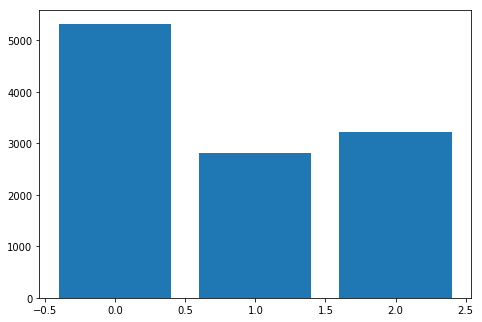

distribution in dict 

0: 19
1: 437
2: 665
3: 1227
4: 943
5: 1451
6: 435
7: 359
8: 181
9: 176
10: 11
11: 18
12: 234


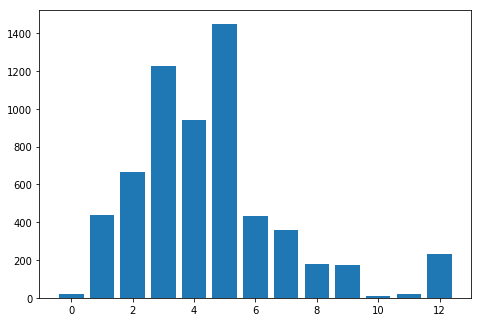

In [12]:
print(len(mean_over_dicts[0]))
print(len(dicts[0]))

_ = osa.analyze_class_in_dic(mean_over_dicts[0], "speed_class")
_ = osa.analyze_class_in_dic(dicts[0], "speed_class")

In [13]:
# test = dade.convert_nero_keys_to_numbers(dicts[0], img_path.format(dirs[0]))

# Slideshow

In [14]:
# i = 0

# slide.slideshow(oversampled_dicts[i], 
#                 img_path.format(dirs[i]), 
#                 minimal_steer=-1.0, maximal_steer=1.0,
#                 minimal_speed=0.0, maximal_speed=1.0,
#                 hz=100, img_file_type="jpg")

# Analyze

distribution in dict 

0: 19
1: 437
2: 665
3: 1227
4: 943
5: 1451
6: 435
7: 359
8: 181
9: 176
10: 11
11: 18
12: 234


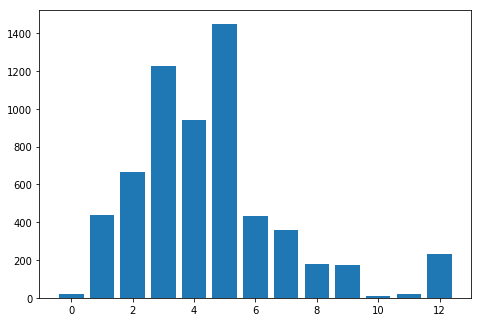

Maintain: 0 | Accelerate: 1 | Deaccelerate: 2


In [15]:
_ = osa.analyze_class_in_dic(dicts[0], "speed_class")
print("Maintain: {} | Accelerate: {} | Deaccelerate: {}".format(
        speed.Speed.MAINTAIN, speed.Speed.ACCELERATE, speed.Speed.DEACCELERATE))

# Oversampling

distribution after oversampling 

0: 1444
1: 1311
2: 1330
3: 1227
4: 943
5: 1451
6: 1305
7: 1436
8: 1448
9: 1408
10: 1441
11: 1440
12: 1404


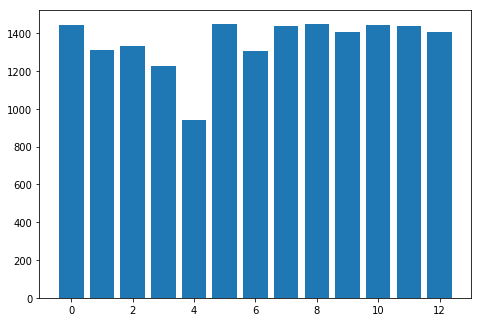

distribution after oversampling 

0: 1095
1: 999
2: 908
3: 865
4: 745
5: 1095
6: 903
7: 1048
8: 1023
9: 1056
10: 1078
11: 1089
12: 0


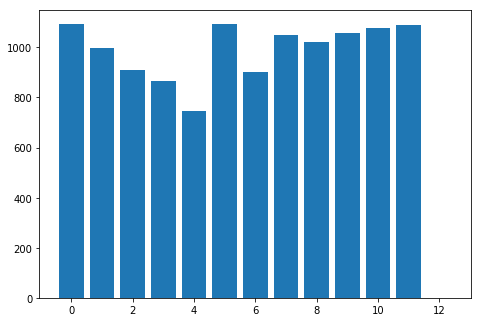

distribution after oversampling 

0: 780
1: 748
2: 704
3: 730
4: 782
5: 584
6: 398
7: 660
8: 721
9: 747
10: 756
11: 780
12: 728


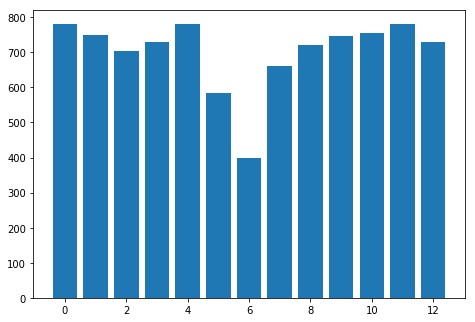

distribution after oversampling 

0: 1368
1: 1368
2: 1309
3: 1012
4: 1093
5: 1233
6: 1376
7: 1144
8: 1215
9: 1334
10: 1357
11: 1376
12: 1020


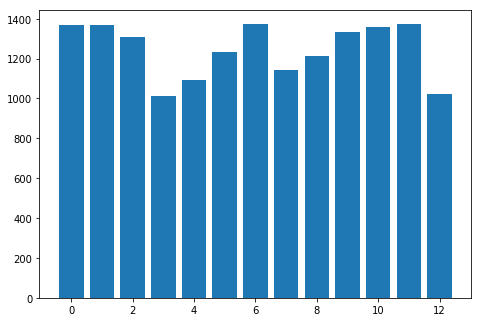

distribution after oversampling 

0: 1026
1: 993
2: 598
3: 962
4: 849
5: 798
6: 1064
7: 1032
8: 990
9: 780
10: 1056
11: 1053
12: 944


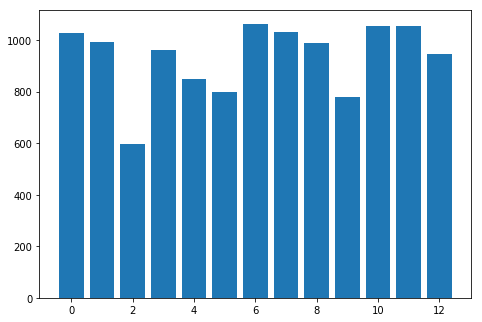

distribution after oversampling 

0: 738
1: 693
2: 704
3: 675
4: 644
5: 452
6: 741
7: 497
8: 536
9: 568
10: 655
11: 696
12: 741


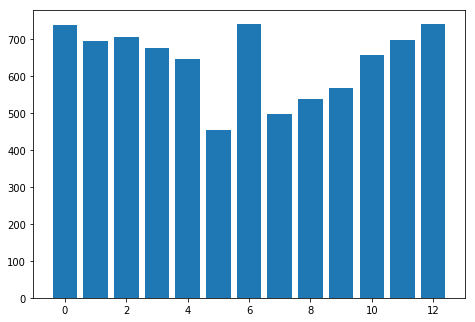

distribution after oversampling 

0: 1056
1: 752
2: 828
3: 747
4: 978
5: 1061
6: 1028
7: 904
8: 559
9: 972
10: 732
11: 1020
12: 1056


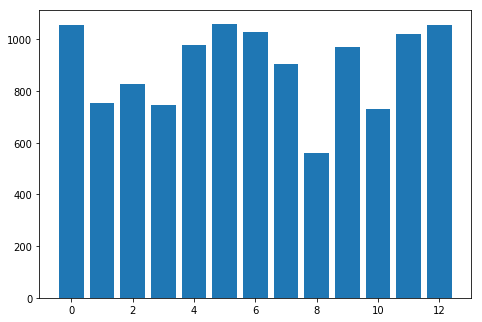

distribution after oversampling 

0: 0
1: 459
2: 451
3: 404
4: 436
5: 474
6: 296
7: 405
8: 350
9: 366
10: 440
11: 462
12: 380


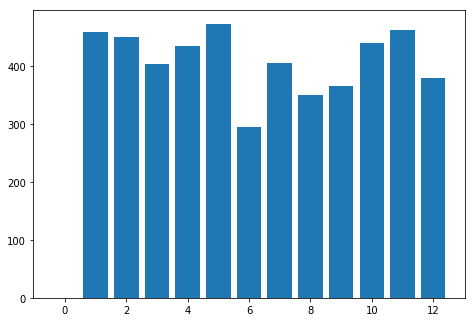

distribution after oversampling 

0: 575
1: 559
2: 574
3: 533
4: 536
5: 576
6: 407
7: 357
8: 531
9: 356
10: 498
11: 450
12: 462


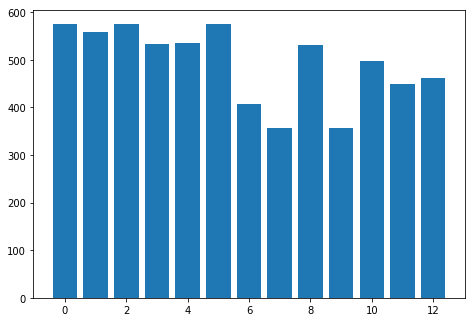

distribution after oversampling 

0: 720
1: 682
2: 645
3: 529
4: 494
5: 383
6: 558
7: 422
8: 416
9: 721
10: 539
11: 640
12: 688


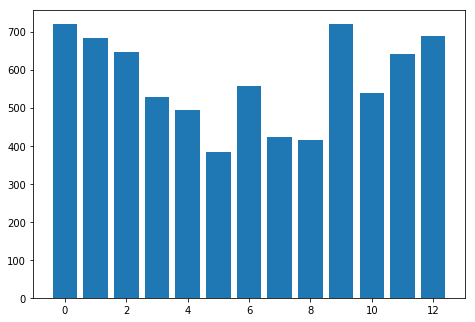

distribution after oversampling 

0: 848
1: 846
2: 531
3: 851
4: 618
5: 812
6: 682
7: 819
8: 784
9: 704
10: 828
11: 717
12: 687


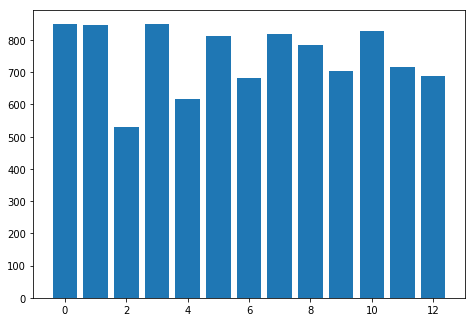

distribution after oversampling 

0: 0
1: 324
2: 616
3: 513
4: 534
5: 348
6: 510
7: 496
8: 448
9: 564
10: 616
11: 608
12: 514


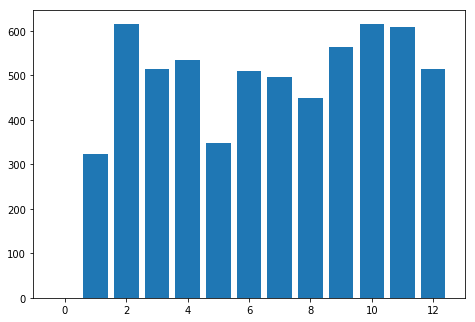

distribution after oversampling 

0: 408
1: 314
2: 423
3: 432
4: 394
5: 227
6: 408
7: 279
8: 244
9: 392
10: 386
11: 416
12: 411


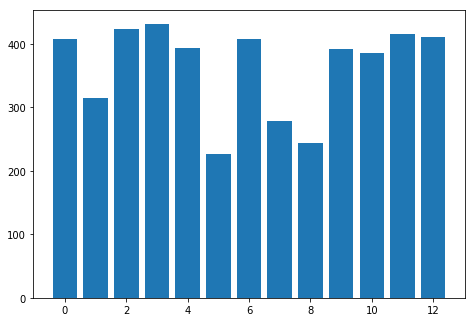

distribution after oversampling 

0: 710
1: 693
2: 702
3: 711
4: 474
5: 686
6: 360
7: 688
8: 389
9: 620
10: 700
11: 704
12: 700


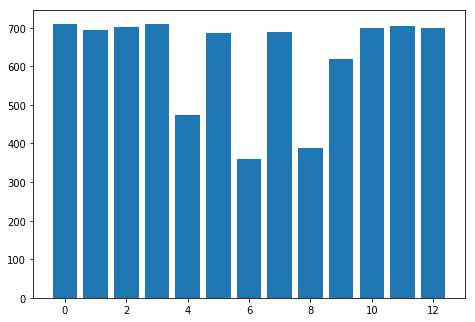

distribution after oversampling 

0: 766
1: 675
2: 572
3: 548
4: 766
5: 421
6: 584
7: 498
8: 422
9: 626
10: 755
11: 586
12: 585


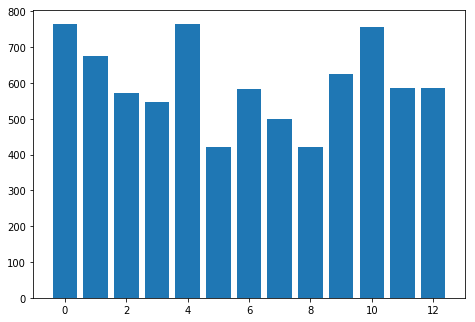

distribution after oversampling 

0: 858
1: 667
2: 541
3: 883
4: 584
5: 771
6: 875
7: 574
8: 644
9: 827
10: 796
11: 824
12: 858


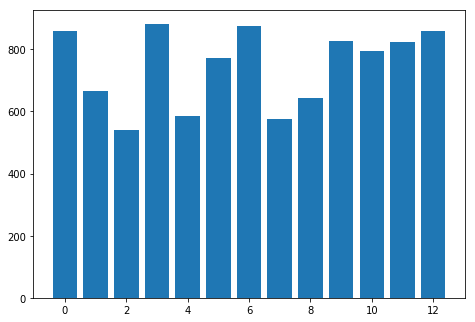

distribution after oversampling 

0: 1016
1: 820
2: 690
3: 809
4: 1070
5: 1046
6: 908
7: 562
8: 868
9: 972
10: 897
11: 1092
12: 1101


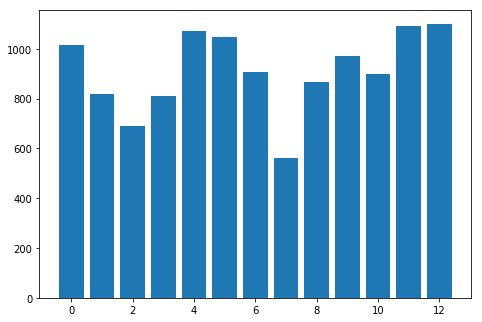

distribution after oversampling 

0: 558
1: 459
2: 549
3: 408
4: 403
5: 333
6: 528
7: 390
8: 567
9: 540
10: 546
11: 560
12: 579


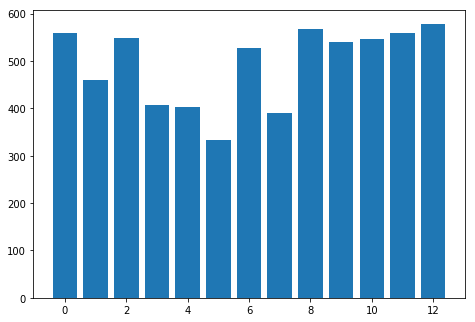

distribution after oversampling 

0: 600
1: 585
2: 468
3: 340
4: 480
5: 553
6: 614
7: 474
8: 558
9: 501
10: 548
11: 594
12: 619


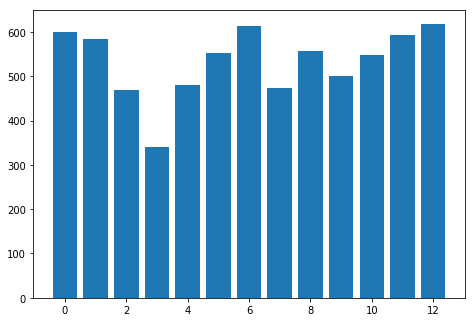

distribution after oversampling 

0: 686
1: 680
2: 671
3: 612
4: 490
5: 487
6: 605
7: 528
8: 510
9: 537
10: 568
11: 624
12: 689


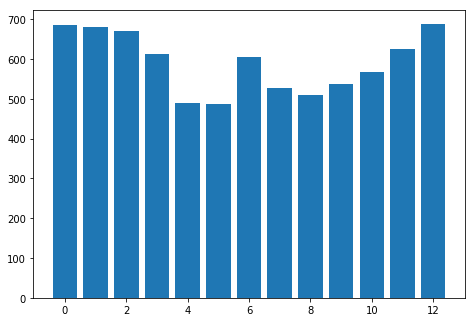

distribution after oversampling 

0: 576
1: 574
2: 574
3: 322
4: 470
5: 490
6: 565
7: 603
8: 474
9: 489
10: 416
11: 484
12: 529


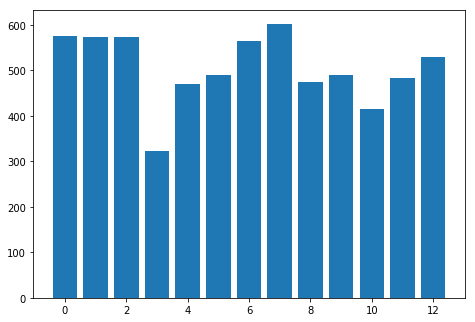

In [16]:
oversampled_dicts = []

class_key = "speed_class"

for dic in dicts:
    analyzed_key_lists = osa.analyze_class_in_dic(dic, class_key, verbose=0)
    od = osa.oversample_class_in_dic_sorted(dic, analyzed_key_lists, class_key, verbose=1)
    
    oversampled_dicts.append(od)

In [17]:
oversampled_valid_dicts = []

class_key = "speed_class"

for dic in valid_dicts:
    analyzed_key_lists = osa.analyze_class_in_dic(dic, class_key, verbose=0)
    od = osa.oversample_class_in_dic_sorted(dic, analyzed_key_lists, class_key, verbose=0)
    
    oversampled_valid_dicts.append(od)

distribution in dict 

0: 512
1: 3812
2: 6149
3: 11927
4: 11005
5: 11428
6: 9655
7: 7350
8: 6351
9: 6093
10: 3552
11: 2155
12: 6479


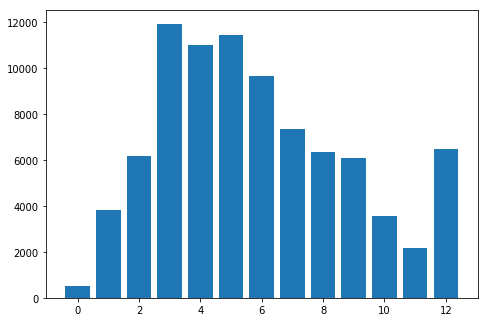

distribution after oversampling 

0: 5120
1: 11436
2: 6149
3: 11927
4: 11005
5: 11428
6: 9655
7: 7350
8: 6351
9: 6093
10: 10656
11: 10775
12: 6479


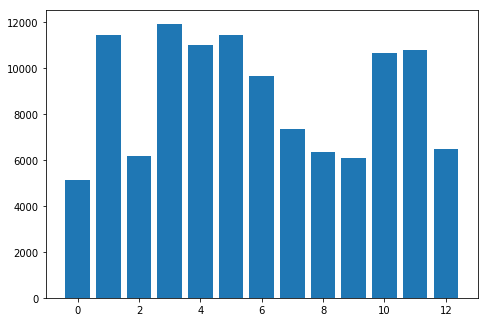

In [18]:
class_key = "speed_class"

analyzed_key_lists = osa.analyze_class_in_dic(combined_dicts, class_key, verbose=1)
oversampled_combined_dicts = osa.oversample_class_in_dic(combined_dicts, analyzed_key_lists, class_key, verbose=1)

distribution in dict 

0: 178
1: 1163
2: 2516
3: 5681
4: 4029
5: 3213
6: 3314
7: 2589
8: 2050
9: 1768
10: 949
11: 216
12: 589


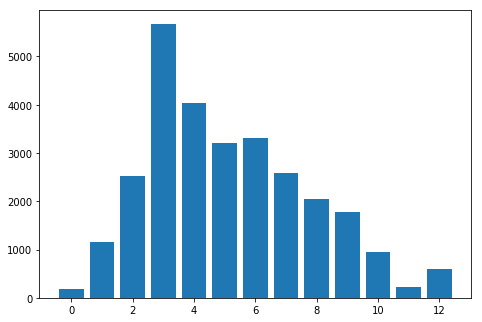

distribution after oversampling 

0: 1780
1: 4652
2: 5032
3: 5681
4: 4029
5: 3213
6: 3314
7: 5178
8: 4100
9: 5304
10: 4745
11: 2160
12: 5301


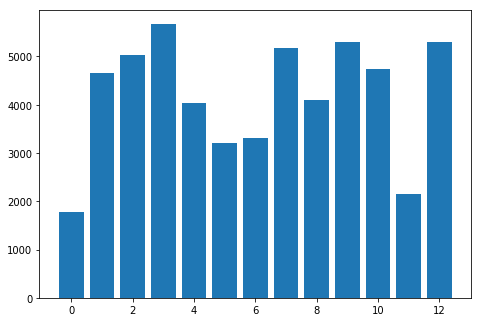

In [19]:
class_key = "speed_class"

analyzed_key_lists = osa.analyze_class_in_dic(combined_valid_dicts, class_key, verbose=1)
oversampled_combined_valid_dicts = osa.oversample_class_in_dic(combined_valid_dicts, analyzed_key_lists, class_key, verbose=1)

# Training

## Data gen

In [20]:
img_processor = img_proc.ImgProcessor()

img_processor.crop = True
img_processor.augment = False

img_processor.fx = 0.1
img_processor.fy = 0.2

In [21]:
batch_size = 1
sequence_size = 64

In [22]:
speed_gens = []

for f, d in zip(dicts, dirs):
    
    gen = ks.SequenceGeneratorSpeedRegression(f, img_path.format(d), img_processor, 
                                    batch_size=1, sequence_size=sequence_size, img_file_type="jpg")
    gen.return_weights = False
    
    speed_gens.append(gen)
    

In [23]:
valid_speed_gens = []

for f, d in zip(valid_dicts, valid_dirs):
    
    gen = ks.SequenceGeneratorSpeedRegression(f, valid_img_path.format(d), img_processor, 
                                    batch_size=1, sequence_size=sequence_size, img_file_type="jpg")
    gen.return_weights = False
    
    valid_speed_gens.append(gen)
    

In [24]:
oversampled_gens = []

for dic, di in zip(oversampled_dicts, dirs):

    oversampled_gen = ks.SequenceGeneratorSpeedRegression(dic, img_path.format(di), img_processor, 
                                                batch_size=1, sequence_size=sequence_size, img_file_type="jpg")
    oversampled_gen.return_weights = False
    
    oversampled_gens.append(oversampled_gen)

In [25]:
oversampled_valid_gens = []

for dic, di in zip(oversampled_valid_dicts, valid_dirs):

    oversampled_gen = ks.SequenceGeneratorSpeedRegression(dic, valid_img_path.format(di), img_processor, 
                                                batch_size=1, sequence_size=sequence_size, img_file_type="jpg")
    oversampled_gen.return_weights = False
    
    oversampled_valid_gens.append(oversampled_gen)

In [26]:
mean_over_gens = []

for dic, di in zip(mean_over_dicts, mean_over_dirs):

    oversampled_gen = ks.SequenceGeneratorSpeed(dic, mean_over_img_path.format(di), img_processor, 
                                                batch_size=1, sequence_size=sequence_size, img_file_type="png")
    oversampled_gen.return_weights = False
    
    mean_over_gens.append(oversampled_gen)

In [27]:
combined_gen = ks.SequenceGeneratorSpeed(combined_valid_dicts, "", img_processor, 
                                         batch_size=1, sequence_size=sequence_size, 
                                         img_file_type="jpg")
combined_gen.return_weights = False



# oversampled_combined_gen = ks.GeneratorSpeed(oversampled_combined_dicts, "", img_processor, 
#                                              batch_size=256, img_file_type="jpg")
# oversampled_combined_gen.return_weights = False

In [28]:
combined_valid_gen = ks.SequenceGeneratorSpeed(combined_valid_dicts, "", img_processor, 
                                               batch_size=1, sequence_size=sequence_size, 
                                               img_file_type="jpg")
combined_valid_gen.return_weights = False

# over_combined_valid_gen = ks.GeneratorSpeed(oversampled_combined_valid_dicts, "", img_processor, batch_size=256, img_file_type="jpg")
# over_combined_valid_gen.return_weights = False

In [29]:
speed_gens_seq = []

for dic, d in zip(dicts, dirs):

    gen = ks.SequenceGeneratorSpeedSeq(dic, img_path.format(d), img_processor, 
                                       batch_size=1, sequence_size=sequence_size, 
                                       img_file_type="jpg")
    gen.return_weights = False
    
    speed_gens_seq.append(gen)

In [30]:
speed_valid_gens_seq = []

for dic, d in zip(valid_dicts, valid_dirs):

    gen = ks.SequenceGeneratorSpeedSeq(dic, valid_img_path.format(d), img_processor, 
                                       batch_size=1, sequence_size=sequence_size, 
                                       img_file_type="jpg")
    gen.return_weights = False
    
    speed_valid_gens_seq.append(gen)

In [31]:
(imgs, _, ) = speed_gens[0][0]
img_shape = imgs[0][0][0].shape
print(img_shape)

(64, 64, 3)


## Model

In [57]:
models.reset_session()

In [58]:
model = models.fabian_ket_lstm_research_b_speed_herta2(img_shape, batch_size, 
                                                      stateful=True, compile_model=True, 
                                                      optimizer="adam", bias=True)

reset_states_callback = kc.KerasRestStatesCallback(model)

Parameter model ref: 0x1c19a0d1f60
Callback  model ref: 0x1c19a0d1f60


In [59]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(1, None, 64, 64, 3 0                                            
__________________________________________________________________________________________________
conv01 (TimeDistributed)        (None, None, 64, 64, 11648       img_input[0][0]                  
__________________________________________________________________________________________________
pool01 (TimeDistributed)        (None, None, 32, 32, 0           conv01[0][0]                     
__________________________________________________________________________________________________
conv_relu01 (TimeDistributed)   (None, None, 32, 32, 0           pool01[0][0]                     
______________________________________________________________________________________________

In [60]:
model_save_file = "fabian_ket_lstm_research_b_speed_herta2.h5"

In [36]:
# model.load_weights( model_save_file )

In [61]:
for _ in range(5):

    for gen in speed_gens:

        model.reset_states()

        history = model.fit_generator(
            generator=gen,
            steps_per_epoch=len(gen),
            # validation_data=oversampled_combined_valid_gen,
            # validation_steps=len(oversampled_combined_valid_gen),
            epochs=1,
            verbose=1,
            workers=1,
            use_multiprocessing=False,
            shuffle=False,
            callbacks=[reset_states_callback])

        model.save_weights( model_save_file )

        print("############################################################################")
        print("")

97/97 [==============================] - 17s 173ms/step - loss: 0.1458 - mean_absolute_error: 0.1458
############################################################################

72/72 [==============================] - 13s 174ms/step - loss: 0.1089 - mean_absolute_error: 0.1089
############################################################################

45/45 [==============================] - 8s 174ms/step - loss: 0.1302 - mean_absolute_error: 0.1302
############################################################################

79/79 [==============================] - 13s 170ms/step - loss: 0.1569 - mean_absolute_error: 0.1569
############################################################################

105/105 [==============================] - 18s 169ms/step - loss: 0.2090 - mean_absolute_error: 0.20904s - loss: 0.2007
############################################################################

49/49 [==============================] - 9s 187ms/step - loss: 0.1410 - mean_absolute_e

############################################################################

79/79 [==============================] - 15s 192ms/step - loss: 0.1585 - mean_absolute_error: 0.1585
############################################################################

105/105 [==============================] - 19s 177ms/step - loss: 0.1976 - mean_absolute_error: 0.1976
############################################################################

49/49 [==============================] - 9s 190ms/step - loss: 0.1455 - mean_absolute_error: 0.1455
############################################################################

84/84 [==============================] - 14s 172ms/step - loss: 0.1635 - mean_absolute_error: 0.1635
############################################################################

40/40 [==============================] - 8s 189ms/step - loss: 0.1541 - mean_absolute_error: 0.1541
############################################################################

57/57 [====================

49/49 [==============================] - 9s 181ms/step - loss: 0.1479 - mean_absolute_error: 0.1479
############################################################################

84/84 [==============================] - 15s 182ms/step - loss: 0.1621 - mean_absolute_error: 0.1621
############################################################################

40/40 [==============================] - 7s 179ms/step - loss: 0.1539 - mean_absolute_error: 0.1539
############################################################################

57/57 [==============================] - 10s 181ms/step - loss: 0.1811 - mean_absolute_error: 0.1811
############################################################################

72/72 [==============================] - 13s 185ms/step - loss: 0.1873 - mean_absolute_error: 0.1873
############################################################################

62/62 [==============================] - 21s 332ms/step - loss: 0.2050 - mean_absolute_error: 0.2050
######

In [25]:
history = model.fit_generator(
    generator=combined_gen,
    steps_per_epoch=len(combined_gen),
    # validation_data=oversampled_combined_valid_gen,
    # validation_steps=len(oversampled_combined_valid_gen),
    epochs=2,
    verbose=1,
    workers=1,
    use_multiprocessing=False,
    shuffle=False,
    callbacks=[reset_states_callback])

Epoch 1/2
215/442 [=============>................] - ETA: 3:04 - loss: 0.4028 - categorical_accuracy: 0.8539

KeyboardInterrupt: 

In [44]:
model.save_weights( model_save_file )

In [48]:
model.reset_states()

In [ ]:
# speed over 0.87(wo over) - 0.90(w over)
# speed 0.87(wo over) - 0.92(w over)
# speed mean over 0.87 (wo over) - 0.92 (w over)

In [62]:
# [1.0949314331812177, 0.6931162627012071]

for gen in valid_speed_gens:
    model.reset_states()
    
    
    pre_speed = 0.0
    error = 0.0
    mid_error = 0.0
    
    i = 0
    
    print("Start with valid ...")
    
    for [img_batch, _], [label_batch] in gen:
        for img_seq, label_seq in zip(img_batch, label_batch):
            for img, label in zip(img_seq, label_seq):
                prediction = np.asscalar(model.predict([ [[img]], [[[pre_speed]]] ], batch_size=1))
                
                pre_speed = prediction
                error += abs(np.asscalar(label) - prediction)
                mid_error += abs(np.asscalar(label) - 0.5)
                i += 1
                
        print("-", end="")
        
    print("")
    print("MAE: {}".format(error / i))
    print("MidE: {}".format(mid_error / i))
    break

Start with valid ...
--------------------------------------------
MAE: 0.1655825456096377
MidE: 0.16075865261002845


In [63]:
for _ in range(10):
    print(model.predict([ [[np.random.rand(64,64,3)]], [[np.random.rand(1)]] ], batch_size=1))

[[[0.84635735]]]
[[[0.9032247]]]
[[[0.91023725]]]
[[[0.8507554]]]
[[[0.89410484]]]
[[[0.85385185]]]
[[[0.5435374]]]
[[[0.3334222]]]
[[[0.8518178]]]
[[[0.91504806]]]


In [46]:
import numpy as np
import cv2
import keras.backend as K
import copy
import time
import os

# own imports
import Src.Models as models
import Src.GenIterator as it

def get_mask_neg_batch_uses_mat(width, height, mask_width=1, mask_height=1):
    
    mask_batch = []
    neg_mask_batch = []
    
    uses = np.zeros((height, width, 1))
    mask = np.ones_like(uses)
    
    for y in range(height - mask_height + 1):
        for x in range(width - mask_width + 1):
                        
            mask[:, :, :] = 1
            mask[(0+y) : (mask_height+y), (0+x) : (mask_width+x), :] = 0       
            mask_batch.append(copy.deepcopy(mask))
            
            neg_mask = (1 - mask)
            neg_mask_batch.append(neg_mask)
            
            uses += neg_mask
    
    mask_batch = np.asarray(mask_batch)
    neg_mask_batch = np.asarray(neg_mask_batch)
    
    return mask_batch, neg_mask_batch, uses
    

def normalize_img(img):
    max_value = np.max(img)
    min_value = np.min(img)

    img -=  min_value
    img /= (max_value - min_value)
        
def heatmap(model, gen, save_dir="test/"):
    
    # create save dir
    t0 = time.time()
    save_dir = save_dir + "{}/".format(t0)
    os.mkdir(save_dir)
    
    n_round = 0
    
    width  = 64
    height = 64
    depth  = 3
    
    
    mask_batch, neg_mask_batch, uses = get_mask_neg_batch_uses_mat(width, height)
    
    length = width * height
    
    print("Start heatmap gen ...")
    
    for img, label in gen:
                
        t0 = time.time()

        result = np.zeros_like(uses)
        
        img_batch = np.asarray([img])
        mask_img_batch = np.multiply(img_batch, mask_batch)
        
        t1 = time.time()
        
        print("start predictions ... ({}sec)".format(t1 - t0))
        
        # you could just predict with the whole batch at once,
        # but then the internal lstm states wouldn't be reseted by keras
        # so we have to do it by ourself
        predictions = model.predict(mask_img_batch)
        
        del mask_img_batch
        
        ground_truth = model.predict([ img_batch ])
        
        del img_batch
        
        print("... predictions done ({}sec)".format(time.time() - t1))
        
        results = []
        
        idx = np.argmax(label)
        
        for neg_mask, predictions in zip(neg_mask_batch, predictions):
            tmp = np.multiply( neg_mask, np.sum(np.abs(predictions - ground_truth)) )
            results.append(tmp)
            
        results = np.asarray(results)
        
        results = np.sum(results, axis=0)
        results /= uses
        
        normalize_img(results)
        
        results = cv2.resize(results, (320, 320))
        results = np.reshape(results, (320, 320, 1))
        
        to_save = np.zeros((320, 320 * 2, depth))
        to_save[:, 0:320, :] += results * 255
        to_save[:, 320: , :] += cv2.resize(img, (320, 320)) * 255
        
        cv2.imwrite("{}{}.png".format(save_dir, time.time()), to_save)
        
        print("Duration {}: {}sec".format(n_round, time.time() - t0))
        print("==================")
        
        n_round += 1
                
    

In [47]:
simple_iter = it.SimpleIterator(speed_gens[0])

In [48]:
heatmap(model, simple_iter)

Start heatmap gen ...
start predictions ... (0.3563222885131836sec)
... predictions done (2.435368299484253sec)
Duration 0: 3.0408380031585693sec
start predictions ... (0.3688516616821289sec)
... predictions done (1.7287940979003906sec)
Duration 1: 2.3224496841430664sec
start predictions ... (0.3592703342437744sec)
... predictions done (1.708542823791504sec)
Duration 2: 2.3220431804656982sec
start predictions ... (0.3463129997253418sec)
... predictions done (1.7105445861816406sec)
Duration 3: 2.2730538845062256sec
start predictions ... (0.36432862281799316sec)
... predictions done (1.7048077583312988sec)
Duration 4: 2.3223652839660645sec
start predictions ... (0.3485116958618164sec)
... predictions done (1.703857660293579sec)
Duration 5: 2.267564296722412sec
start predictions ... (0.3579256534576416sec)
... predictions done (1.7167248725891113sec)
Duration 6: 2.3068621158599854sec
start predictions ... (0.3633279800415039sec)
... predictions done (1.7045402526855469sec)
Duration 7: 2.2

Duration 56: 2.2089951038360596sec
start predictions ... (0.3653438091278076sec)
... predictions done (1.6504766941070557sec)
Duration 57: 2.225010633468628sec
start predictions ... (0.3863487243652344sec)
... predictions done (1.6364784240722656sec)
Duration 58: 2.2270126342773438sec
start predictions ... (0.35231852531433105sec)
... predictions done (1.6474885940551758sec)
Duration 59: 2.2049927711486816sec
start predictions ... (0.35031771659851074sec)
... predictions done (1.6284692287445068sec)
Duration 60: 2.177967071533203sec
start predictions ... (0.35231852531433105sec)
... predictions done (1.6424839496612549sec)
Duration 61: 2.2119994163513184sec
start predictions ... (0.35231781005859375sec)
... predictions done (1.628472089767456sec)
Duration 62: 2.1799685955047607sec
start predictions ... (0.3613278865814209sec)
... predictions done (1.6324737071990967sec)
Duration 63: 2.2019903659820557sec
start predictions ... (0.3533194065093994sec)
... predictions done (1.633475780487

... predictions done (1.7050230503082275sec)
Duration 113: 2.267441749572754sec
start predictions ... (0.3520052433013916sec)
... predictions done (1.7004570960998535sec)
Duration 114: 2.259648323059082sec
start predictions ... (0.37433886528015137sec)
... predictions done (1.684523582458496sec)
Duration 115: 2.2900710105895996sec
start predictions ... (0.3513178825378418sec)
... predictions done (1.681520700454712sec)
Duration 116: 2.234105110168457sec
start predictions ... (0.3553135395050049sec)
... predictions done (1.6875457763671875sec)
Duration 117: 2.2551984786987305sec
start predictions ... (0.3656177520751953sec)
... predictions done (1.6785156726837158sec)
Duration 118: 2.2323050498962402sec
start predictions ... (0.35932445526123047sec)
... predictions done (1.7075421810150146sec)
Duration 119: 2.2980761528015137sec
start predictions ... (0.35231995582580566sec)
... predictions done (1.6604995727539062sec)
Duration 120: 2.205994129180908sec
start predictions ... (0.36833286

Duration 169: 2.3153250217437744sec
start predictions ... (0.37003469467163086sec)
... predictions done (1.6998193264007568sec)
Duration 170: 2.272616147994995sec
start predictions ... (0.34345412254333496sec)
... predictions done (1.7164978981018066sec)
Duration 171: 2.2703158855438232sec
start predictions ... (0.3800516128540039sec)
... predictions done (1.699634313583374sec)
Duration 172: 2.290041446685791sec
start predictions ... (0.37001729011535645sec)
... predictions done (1.7406344413757324sec)
Duration 173: 2.303351879119873sec
start predictions ... (0.36728835105895996sec)
... predictions done (1.7960896492004395sec)
Duration 174: 2.3756210803985596sec
start predictions ... (0.37935972213745117sec)
... predictions done (1.7006161212921143sec)
Duration 175: 2.3100221157073975sec
start predictions ... (0.36002421379089355sec)
... predictions done (1.7298972606658936sec)
Duration 176: 2.3192009925842285sec
start predictions ... (0.38980531692504883sec)
... predictions done (1.74

start predictions ... (0.3558943271636963sec)
... predictions done (1.6887600421905518sec)
Duration 226: 2.253843069076538sec
start predictions ... (0.35431981086730957sec)
... predictions done (1.7438054084777832sec)
Duration 227: 2.2903058528900146sec
start predictions ... (0.35329651832580566sec)
... predictions done (1.7117033004760742sec)
Duration 228: 2.264918088912964sec
start predictions ... (0.3947410583496094sec)
... predictions done (1.6911652088165283sec)
Duration 229: 2.2860872745513916sec
start predictions ... (0.36933469772338867sec)
... predictions done (1.6950459480285645sec)
Duration 230: 2.288583517074585sec
start predictions ... (0.3583223819732666sec)
... predictions done (1.7065417766571045sec)
Duration 231: 2.26373291015625sec
start predictions ... (0.3849213123321533sec)
... predictions done (1.6977267265319824sec)
Duration 232: 2.2828290462493896sec
start predictions ... (0.37734103202819824sec)
... predictions done (1.7035393714904785sec)
Duration 233: 2.28606

... predictions done (1.6347770690917969sec)
Duration 282: 2.2332584857940674sec
start predictions ... (0.38359665870666504sec)
... predictions done (1.6178321838378906sec)
Duration 283: 2.208897352218628sec
start predictions ... (0.37202882766723633sec)
... predictions done (1.6291537284851074sec)
Duration 284: 2.2551088333129883sec
start predictions ... (0.3536229133605957sec)
... predictions done (1.600170373916626sec)
Duration 285: 2.1921041011810303sec
start predictions ... (0.3857276439666748sec)
... predictions done (1.6243226528167725sec)
Duration 286: 2.2262227535247803sec
start predictions ... (0.35791540145874023sec)
... predictions done (1.6203794479370117sec)
Duration 287: 2.1833395957946777sec
start predictions ... (0.3622715473175049sec)
... predictions done (1.614905595779419sec)
Duration 288: 2.1976799964904785sec
start predictions ... (0.36217617988586426sec)
... predictions done (1.6324138641357422sec)
Duration 289: 2.1951310634613037sec
start predictions ... (0.3735

Duration 338: 2.2700185775756836sec
start predictions ... (0.3564879894256592sec)
... predictions done (1.6437740325927734sec)
Duration 339: 2.2103683948516846sec
start predictions ... (0.3798947334289551sec)
... predictions done (1.6600008010864258sec)
Duration 340: 2.2489922046661377sec
start predictions ... (0.3610038757324219sec)
... predictions done (1.6799006462097168sec)
Duration 341: 2.2531702518463135sec
start predictions ... (0.3578808307647705sec)
... predictions done (1.6498501300811768sec)
Duration 342: 2.2040164470672607sec
start predictions ... (0.35934925079345703sec)
... predictions done (1.6541619300842285sec)
Duration 343: 2.233638286590576sec
start predictions ... (0.390183687210083sec)
... predictions done (1.6849589347839355sec)
Duration 344: 2.280155658721924sec
start predictions ... (0.36002683639526367sec)
... predictions done (1.6697499752044678sec)
Duration 345: 2.2599565982818604sec
start predictions ... (0.371074914932251sec)
... predictions done (1.6788067

start predictions ... (0.40299558639526367sec)
... predictions done (1.7198827266693115sec)
Duration 395: 2.342590093612671sec
start predictions ... (0.3826775550842285sec)
... predictions done (1.7326247692108154sec)
Duration 396: 2.3304359912872314sec
start predictions ... (0.3542630672454834sec)
... predictions done (1.74566650390625sec)
Duration 397: 2.289884567260742sec
start predictions ... (0.37510251998901367sec)
... predictions done (1.7050061225891113sec)
Duration 398: 2.309741497039795sec
start predictions ... (0.36533665657043457sec)
... predictions done (1.725078821182251sec)
Duration 399: 2.3001346588134766sec
start predictions ... (0.4018526077270508sec)
... predictions done (1.7144811153411865sec)
Duration 400: 2.362712860107422sec
start predictions ... (0.36037206649780273sec)
... predictions done (1.6971774101257324sec)
Duration 401: 2.247483730316162sec
start predictions ... (0.37627243995666504sec)
... predictions done (1.7137768268585205sec)
Duration 402: 2.3000411

... predictions done (1.6979846954345703sec)
Duration 451: 2.310102939605713sec
start predictions ... (0.4050302505493164sec)
... predictions done (1.7148768901824951sec)
Duration 452: 2.3399410247802734sec
start predictions ... (0.4100222587585449sec)
... predictions done (1.6899828910827637sec)
Duration 453: 2.3300623893737793sec
start predictions ... (0.38066911697387695sec)
... predictions done (1.6992194652557373sec)
Duration 454: 2.2800002098083496sec
start predictions ... (0.40993523597717285sec)
... predictions done (1.699981451034546sec)
Duration 455: 2.3099629878997803sec
start predictions ... (0.41002559661865234sec)
... predictions done (1.6999356746673584sec)
Duration 456: 2.3297131061553955sec
start predictions ... (0.3803071975708008sec)
... predictions done (1.7096858024597168sec)
Duration 457: 2.3101627826690674sec
start predictions ... (0.3802354335784912sec)
... predictions done (1.6898984909057617sec)
Duration 458: 2.2800915241241455sec
start predictions ... (0.3601

Duration 507: 2.309964179992676sec
start predictions ... (0.4000115394592285sec)
... predictions done (1.6899762153625488sec)
Duration 508: 2.309947967529297sec
start predictions ... (0.40006542205810547sec)
... predictions done (1.7047467231750488sec)
Duration 509: 2.3075108528137207sec
start predictions ... (0.39252614974975586sec)
... predictions done (1.710024118423462sec)
Duration 510: 2.3125927448272705sec
start predictions ... (0.36049318313598633sec)
... predictions done (1.699110746383667sec)
Duration 511: 2.280050039291382sec
start predictions ... (0.37999820709228516sec)
... predictions done (1.699981689453125sec)
Duration 512: 2.2896652221679688sec
start predictions ... (0.40038418769836426sec)
... predictions done (1.7199468612670898sec)
Duration 513: 2.349976062774658sec
start predictions ... (0.42037463188171387sec)
... predictions done (1.7200183868408203sec)
Duration 514: 2.3704497814178467sec
start predictions ... (0.3896346092224121sec)
... predictions done (1.720343

start predictions ... (0.36005377769470215sec)
... predictions done (1.719961404800415sec)
Duration 620: 2.2899253368377686sec
start predictions ... (0.4026975631713867sec)
... predictions done (1.7188258171081543sec)
Duration 621: 2.3216681480407715sec
start predictions ... (0.40044641494750977sec)
... predictions done (1.7076857089996338sec)
Duration 622: 2.3385634422302246sec
start predictions ... (0.36991214752197266sec)
... predictions done (1.749833106994629sec)
Duration 623: 2.349726915359497sec
start predictions ... (0.390167236328125sec)
... predictions done (1.709930658340454sec)
Duration 624: 2.32987904548645sec
start predictions ... (0.40404319763183594sec)
... predictions done (1.7361977100372314sec)
Duration 625: 2.335134983062744sec
start predictions ... (0.3661043643951416sec)
... predictions done (1.714040994644165sec)
Duration 626: 2.2871594429016113sec
start predictions ... (0.3686025142669678sec)
... predictions done (1.6923670768737793sec)
Duration 627: 2.250974178

... predictions done (1.710090160369873sec)
Duration 676: 2.319796323776245sec
start predictions ... (0.3802816867828369sec)
... predictions done (1.7199714183807373sec)
Duration 677: 2.2903389930725098sec
start predictions ... (0.42980027198791504sec)
... predictions done (1.720046043395996sec)
Duration 678: 2.369673490524292sec
start predictions ... (0.3601865768432617sec)
... predictions done (1.7199878692626953sec)
Duration 679: 2.290250778198242sec
start predictions ... (0.39106035232543945sec)
... predictions done (1.7389447689056396sec)
Duration 680: 2.3298139572143555sec
start predictions ... (0.37224483489990234sec)
... predictions done (1.7279863357543945sec)
Duration 681: 2.300124406814575sec
start predictions ... (0.3649022579193115sec)
... predictions done (1.6947691440582275sec)
Duration 682: 2.2900822162628174sec
start predictions ... (0.39997029304504395sec)
... predictions done (1.7200806140899658sec)
Duration 683: 2.3161821365356445sec
start predictions ... (0.3810188

Duration 732: 2.2799956798553467sec
start predictions ... (0.36728906631469727sec)
... predictions done (1.7229888439178467sec)
Duration 733: 2.300114154815674sec
start predictions ... (0.37027835845947266sec)
... predictions done (1.7199604511260986sec)
Duration 734: 2.3087656497955322sec
start predictions ... (0.4414677619934082sec)
... predictions done (1.6995882987976074sec)
Duration 735: 2.3514602184295654sec
start predictions ... (0.39003586769104004sec)
... predictions done (1.7099506855010986sec)
Duration 736: 2.3055055141448975sec
start predictions ... (0.3614993095397949sec)
... predictions done (1.7029776573181152sec)
Duration 737: 2.2844035625457764sec
start predictions ... (0.37009143829345703sec)
... predictions done (1.7099413871765137sec)
Duration 738: 2.2770535945892334sec
start predictions ... (0.42308497428894043sec)
... predictions done (1.679901123046875sec)
Duration 739: 2.3231394290924072sec
start predictions ... (0.38991212844848633sec)
... predictions done (1.7

start predictions ... (0.40489721298217773sec)
... predictions done (1.7051665782928467sec)
Duration 789: 2.320021867752075sec
start predictions ... (0.36701273918151855sec)
... predictions done (1.7226152420043945sec)
Duration 790: 2.3197720050811768sec
start predictions ... (0.42009663581848145sec)
... predictions done (1.6901049613952637sec)
Duration 791: 2.3202996253967285sec
start predictions ... (0.3799591064453125sec)
... predictions done (1.7299225330352783sec)
Duration 792: 2.3698811531066895sec
start predictions ... (0.40004920959472656sec)
... predictions done (1.7299928665161133sec)
Duration 793: 2.320037841796875sec
start predictions ... (0.3999216556549072sec)
... predictions done (1.7049343585968018sec)
Duration 794: 2.331432580947876sec
start predictions ... (0.3744699954986572sec)
... predictions done (1.7138826847076416sec)
Duration 795: 2.2986698150634766sec
start predictions ... (0.355374813079834sec)
... predictions done (1.6944663524627686sec)
Duration 796: 2.2799

... predictions done (1.7000482082366943sec)
Duration 845: 2.2999610900878906sec
start predictions ... (0.3800208568572998sec)
... predictions done (1.6899561882019043sec)
Duration 846: 2.32997727394104sec
start predictions ... (0.4099876880645752sec)
... predictions done (1.7200210094451904sec)
Duration 847: 2.3400847911834717sec
start predictions ... (0.38607072830200195sec)
... predictions done (1.7208595275878906sec)
Duration 848: 2.3199727535247803sec
start predictions ... (0.3769409656524658sec)
... predictions done (1.7630407810211182sec)
Duration 849: 2.3599789142608643sec
start predictions ... (0.43966102600097656sec)
... predictions done (1.7003707885742188sec)
Duration 850: 2.3499958515167236sec
start predictions ... (0.39113593101501465sec)
... predictions done (1.7085256576538086sec)
Duration 851: 2.3200597763061523sec
start predictions ... (0.37997865676879883sec)
... predictions done (1.7200062274932861sec)
Duration 852: 2.3100333213806152sec
start predictions ... (0.369

Duration 901: 2.3200230598449707sec
start predictions ... (0.4000406265258789sec)
... predictions done (1.6999893188476562sec)
Duration 902: 2.3297674655914307sec
start predictions ... (0.3562161922454834sec)
... predictions done (1.7039837837219238sec)
Duration 903: 2.2803077697753906sec
start predictions ... (0.3699452877044678sec)
... predictions done (1.699949026107788sec)
Duration 904: 2.289914131164551sec
start predictions ... (0.3697981834411621sec)
... predictions done (1.7102437019348145sec)
Duration 905: 2.307138204574585sec
start predictions ... (0.37255311012268066sec)
... predictions done (1.7003834247589111sec)
Duration 906: 2.2828893661499023sec
start predictions ... (0.3899977207183838sec)
... predictions done (1.690058708190918sec)
Duration 907: 2.299645185470581sec
start predictions ... (0.40039849281311035sec)
... predictions done (1.7099735736846924sec)
Duration 908: 2.3304293155670166sec
start predictions ... (0.3597121238708496sec)
... predictions done (1.68987226

start predictions ... (0.43990039825439453sec)
... predictions done (1.7601654529571533sec)
Duration 958: 2.399956226348877sec
start predictions ... (0.3730621337890625sec)
... predictions done (1.710874080657959sec)
Duration 959: 2.329990863800049sec
start predictions ... (0.38677287101745605sec)
... predictions done (1.718735694885254sec)
Duration 960: 2.2799384593963623sec
start predictions ... (0.3699219226837158sec)
... predictions done (1.7097892761230469sec)
Duration 961: 2.279960870742798sec
start predictions ... (0.42003822326660156sec)
... predictions done (1.7000219821929932sec)
Duration 962: 2.3174147605895996sec
start predictions ... (0.3751389980316162sec)
... predictions done (1.7271983623504639sec)
Duration 963: 2.322256565093994sec
start predictions ... (0.38445305824279785sec)
... predictions done (1.7405445575714111sec)
Duration 964: 2.325437307357788sec
start predictions ... (0.3648974895477295sec)
... predictions done (1.719740390777588sec)
Duration 965: 2.30497384

... predictions done (1.719282865524292sec)
Duration 1014: 2.3094046115875244sec
start predictions ... (0.44005632400512695sec)
... predictions done (1.7099599838256836sec)
Duration 1015: 2.4097115993499756sec
start predictions ... (0.3703787326812744sec)
... predictions done (1.6999406814575195sec)
Duration 1016: 2.270292043685913sec
start predictions ... (0.4001271724700928sec)
... predictions done (1.6900439262390137sec)
Duration 1017: 2.316757917404175sec
start predictions ... (0.36331820487976074sec)
... predictions done (1.6998498439788818sec)
Duration 1018: 2.2732696533203125sec
start predictions ... (0.3601210117340088sec)
... predictions done (1.7097561359405518sec)
Duration 1019: 2.290076971054077sec
start predictions ... (0.4100768566131592sec)
... predictions done (1.6899313926696777sec)
Duration 1020: 2.3004603385925293sec
start predictions ... (0.37142419815063477sec)
... predictions done (1.7180604934692383sec)
Duration 1021: 2.2992308139801025sec
start predictions ... (

KeyboardInterrupt: 

# Create Mean Oversample Data

In [7]:
for dic, d in zip(dicts, dirs):
    
    tmp = dade.convert_nero_keys_to_numbers(dic, img_path.format(d))
    osa.oversamle_stream_class_data(tmp, img_path.format(d), 
                                    "Z:/ForschB/NeuroRace-Sim/forschB_data_mean_over/{}".format(d), 
                                    class_key="speed_class",
                                    img_file_type="jpg", dest_img_file_type="png")